# TESTBED FOR FULL STATE FEEDBACK

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

This notebook describes the proportional, integral, and differential controllers.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

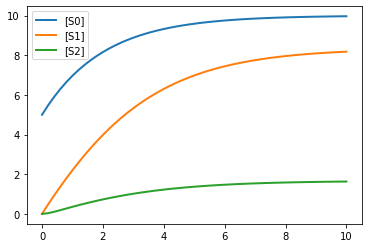

In [3]:
MODEL = """
-> S0; 5
S0 -> S1; k0*S0
S1 -> S2; k1*S1
S2 -> S1; k2*S2
S2 -> ; k3*S2

k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
S0 = 5
S1 = 0
S2 = 0
"""
RR = te.loada(MODEL)
RR.simulate(0, 10)
RR.plot()

# Calculating symbolic eigenvalues

In [4]:
k0, k1, k2, k3, S1, S2, S0 = sympy.symbols("k0, k1, k2, k3, S1, S2, S0")

In [5]:
A = sympy.Matrix([[-k1, k2], [k1, -k2-k3]])
A

Matrix([
[-k1,       k2],
[ k1, -k2 - k3]])

In [110]:
Ap = A.subs({k1:1, k2:2, k3:3})
Ap.as_real_imag()[0]

Matrix([
[-1,  2],
[ 1, -5]])

In [115]:
mat = np.array([[-1, 2], [1, -5]])
np.linalg.eig(mat)

(array([-0.55051026, -5.44948974]),
 array([[ 0.97566304, -0.40997761],
        [ 0.21927526,  0.91209559]]))

In [118]:
3 - np.sqrt(6)

0.5505102572168221

In [6]:
eigenvalues = list(A.eigenvals().keys())
eigenvalues[1].simplify()

-k1/2 - k2/2 - k3/2 + sqrt(k1**2 + 2*k1*k2 - 2*k1*k3 + k2**2 + 2*k2*k3 + k3**2)/2

In [7]:
sympy.expand((k1 + k2 + k3)**2)

k1**2 + 2*k1*k2 + 2*k1*k3 + k2**2 + 2*k2*k3 + k3**2

In [8]:
expr1 = -(k1 +k2 + k3) + sympy.sqrt( (k1 + k2 +k3)**2 - 4*(k1*(k3-k2)))

In [9]:
sympy.N(expr1.subs({k1: 1, k2: 2, k3: 3}))

-0.343145750507620

In [10]:
expr2 = -(k1 +k2 + k3) - sympy.sqrt( (k1 + k2 +k3)**2 - 4*(k1*(k3-k2)))
sympy.N(expr2.subs({k1: 1, k2: 2, k3: 3}))

-11.6568542494924

# DC Gain

In [174]:
Ap = np.array([ [15, 25], [-1, 5]])
Ap_inv = np.linalg.inv(Ap)
print(Ap_inv)
App = np.matmul(Ap_inv, np.array([ [0.5], [0]]))
print(App)
print(np.matmul(np.array([0, 1]), App))              

[[ 0.05 -0.25]
 [ 0.01  0.15]]
[[0.025]
 [0.005]]
[0.005]


# Full State Feedback

In [170]:
np.matmul(Ap, Ap_inv)

array([[ 1.00000000e+00, -1.38777878e-16],
       [-1.73472348e-18,  1.00000000e+00]])

## Full State Controller

In [61]:
def makeController(name, kp_vec):
    """
    Creates a full state feedback controller.
    
    Parameters
    ----------
    name: str
        Name of the system
    kp_vec: list-float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    kp_vec = np.array(kp_vec)
    def outfcn(_, __, u_vec, ___):
        # u_vec: list-float - vector of internal state deviations
        ref = u_vec[0]
        arr = np.array(u_vec[1:])
        output = ref - kp_vec.dot(arr)
        return output
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=['ref', 'in1', 'in2'], outputs=['out'],
        name=name)

# Tests
kp_vec = [1, 2]
controller = makeController("controller", kp_vec)
times = [0, 1, 2, 3, 4]
refs = np.repeat(1, len(times))
U = np.array(list(zip(refs, times, times)))
U = U.transpose()
result = control.input_output_response(controller, T=times, U=U)
assert(len(result.y[0]) == len(times))
assert(result.y[0][1] == -2)
print("OK!")

OK!


In [142]:
def makeFullStateFeedbackController(name, ctlsb, factor=1.0, poles=-2, time=0):
    """
    Creates a full state feedback controller for an SBML model where the system is linearized
    at the specified time.
    
    Parameters
    ----------
    name: str
        Name of the system
    ctlsb: ControlSBML
        SISO system
    factor: float
        factor for adjusting the reference input
    poles: list-float/float
        Desired poles
    time: float
        Time where system is lienarized
    
    Returns
    -------
    control.NonlinearIOSystem
       inputs:
           <state_variable> (excluding the input)
           ref: reference input
       outputs:
           out
    """
    REF = "ref"
    # Validity Checks
    if len(ctlsb.input_names) != 1:
        raise ValueError("SBML model must have a single input. Has: %s" % str(ctlsb.input_names))
    # Initializations
    state_space = ctlsb.makeStateSpace(time=time)
    controller_input_names = [n for n in ctlsb.state_names if not n in ctlsb.input_names]
    controller_input_names.insert(0, REF)  # first input
    num_state_input = len(controller_input_names) - 1
    try:
        _ = len(poles)
        poles = np.array(poles)
    except:
        poles = np.array([poles + 0.1*n for n in range(num_state_input)])
    # Calculate the gain matrix
    kp_vec = control.place(state_space.A, state_space.B, poles)
    def outfcn(time, _, u_vec, __):
        # u_vec: list-float - reference, state variables
        ref = factor*u_vec[0]
        arr = np.array(u_vec[1:])
        output = ref - kp_vec.dot(arr)
        return output
    #
    return control.NonlinearIOSystem(
        None, outfcn, inputs=controller_input_names, outputs=['out'],
        name=name)

# Tests
ctlsb = ctl.ControlSBML(MODEL, input_names=["S0"], output_names=["S2"])
controller = makeFullStateFeedbackController("controller", ctlsb, factor=1.0, poles=-10, time=1)
times = [0, 1, 2, 3, 4]
U = np.array([(1, 1, 1,) for _ in range(len(times))])
U = U.transpose()
result = control.input_output_response(controller, T=times, U=U)
assert(len(result.y[0]) == len(times))
print("OK!")

OK!


In [139]:
result.y

array([[-79.8, -79.8, -79.8, -79.8, -79.8]])

In [125]:
def calcKp(lambda1, lambda2, k0=0.5, k1=1, k2=2, k3=3):
    """
    Calculates the proportional constants for MODEL.
    """
    kp1 = (-lambda1 - lambda2 - k1 - k2 - k3)/k0
    kp2 = (lambda1*lambda2 - k1*k3 - kp1*k0*(k2 + k3))/(k0*k1)
    return np.array([kp1, kp2])

# Tests
poles = calcKp(-10, -11)
assert(poles[1] == 64)
print("OK!")

OK!


## Network

In [144]:
# Create elements
CTLSB = ctl.ControlSBML(MODEL, input_names=["S0"], output_names=["S1", "S2"])
system = CTLSB.makeNonlinearIOSystem("system")
controller = makeController("controller", calcKp(-10, -10))

In [120]:
state_space = ctlsb.makeStateSpace()
state_space

StateSpace(array([[-1.,  2.],
       [ 1., -5.]]), array([[0.5],
       [0. ]]), array([[1., 0.],
       [0., 1.]]), array([[0.],
       [0.]]))

In [122]:
control.place(state_space.A, state_space.B, [-10, -11])

array([[30., 64.]])

In [102]:
# Create the closed loop system with a disturbance input.
closed_loop = control.interconnect(
  [system, controller ], 
  connections=[
    ['controller.in1', 'system.S1'],    
    ['controller.in2', 'system.S2'], 
    ["system.S0", "controller.out"],   
  ],
  inplist=["controller.ref"],
  outlist = ["controller.out", "system.S1", "system.S2"],
)

In [151]:
controller = makeFullStateFeedbackController("controller", CTLSB, factor=1, poles=-0.1)
# Create the closed loop system with a disturbance input.
closed_loop = control.interconnect(
  [system, controller ], 
  connections=[
    ['controller.S1', 'system.S1'],    
    ['controller.S2', 'system.S2'], 
    ["system.S0", "controller.out"],   
  ],
  inplist=["controller.ref"],
  outlist = ["controller.out", "system.S1", "system.S2"],
)

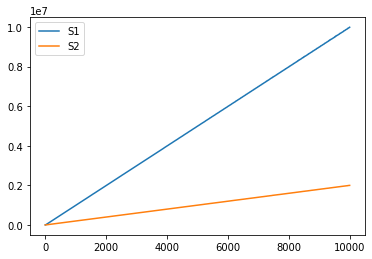

In [155]:
X0 = ctl.makeStateVector(closed_loop)
times = ctl.makeSimulationTimes(end_time=10, points_per_time=10)
result = control.input_output_response(closed_loop, T=times, U=40, X0=X0)
plt.plot(result.t.flatten(), result.outputs[1].flatten())
plt.plot(result.t.flatten(), result.outputs[2].flatten())
_ = plt.legend(["S1", "S2"])

In [156]:
closed_loop.linearize(X0, 5).pole()

array([ 0.00000000e+00, -4.44087789e-09, -9.99999956e-02])